In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
from misc import *

from sklearn.decomposition import PCA
import phate

## 1. Import/generate Data

### 1.1 Load multiple simulated trajectory from Mulistrand

In [4]:
# load multiple trajectories from multiple files
folder_name = "data/helix_assos_PT0/assos_PT0_1sim_20C"
# define absorbing (final) state structure
FINAL_STRUCTURE = "(((((((((((((((((((((((((+)))))))))))))))))))))))))"
num_files = 100

SIMS,SIMS_retrieve,SIMS_concat = load_multitrj(folder_name,FINAL_STRUCTURE,num_files)

print("SIM: ", len(SIMS))
print("SIM_retrieve: ", SIMS_retrieve.shape)
print("SIM_concat: ", len(SIMS_concat))

SIM:  198536
SIM_retrieve:  (198536, 3)
SIM_concat:  198536


### 1.2 Load single simulated trajectory from Mulistrand

In [5]:
# load text file
f = open('./data/helix_assos/assos_PT3_1sim_20C_21.txt', 'r') # PT3 
STRAND_NAME = "assos_PT3_1sim_20C_21"

# f = open('./data/helix_assos/assos_PT0_1sim_20C_51.txt', 'r') # PT0
# STRAND_NAME = "assos_PT0_1sim_20C_51"

""" Dimenstions of SIM list 
SIM: [[sim1], [sim2], ...]
sim: [[state1], [state2], ...]
state: [structure, time, energy]
"""
# define absorbing (final) state structure
FINAL_STRUCTURE = "(((((((((((((((((((((((((+)))))))))))))))))))))))))"

SIM = loadtrj(f,FINAL_STRUCTURE,type="Multiple")
SIM_retrieve = np.array(SIM)
SIM_concat = concat_helix_structures(SIM) 

print("SIM: ", len(SIM))
print("SIM_retrieve: ", SIM_retrieve.shape)
print("SIM_concat: ", len(SIM_concat))

SIM:  1780
SIM_retrieve:  (1780, 3)
SIM_concat:  1780


### 2. Convert dot-paren to adjacency matrix

In [6]:
""" Dimenstions of SIM_adj list 
SIM_adj: N*m*m
    N: number of states in the trajectory
    m: number of nucleotides in the state (strand)
"""
# get single trajectory's data
# get adjacency matrix, energy, and holding time for each state
SIM_adj,SIM_G,SIM_T,SIM_HT = sim_adj(SIM_concat)
print(SIM_adj.shape,SIM_G.shape,SIM_T.shape,SIM_HT.shape)


# get multiple trajectories' data
SIMS_adj, SIMS_G, SIMS_T, SIMS_HT = sim_adj(SIMS_concat)
print(SIMS_adj.shape,SIMS_G.shape,SIMS_T.shape,SIMS_HT.shape)

(1780, 50, 50) (1780,) (1780,) (1780,)
(198536, 50, 50) (198536,) (198536,) (198536,)


In [7]:
# get unique states adjacency matrix with their occupancy density, get unique energy, and time;
# and their corresponding indices

# single trajectory
indices,occ_density,SIM_adj_uniq,SIM_G_uniq,SIM_T_uniq,SIM_HT_uniq \
     = get_unique(SIM_concat,SIM_adj,SIM_G,SIM_T,SIM_HT)
print(indices.shape, occ_density.shape, SIM_adj_uniq.shape,SIM_G_uniq.shape,SIM_T_uniq.shape,SIM_HT_uniq.shape)


# multiple trajectories
indices_S,occ_density_S,SIMS_adj_uniq,SIMS_G_uniq,SIMS_T_uniq,SIMS_HT_uniq \
     = get_unique(SIMS_concat,SIMS_adj,SIMS_G,SIMS_T,SIMS_HT)
print(indices_S.shape, occ_density_S.shape, SIMS_adj_uniq.shape,SIMS_G_uniq.shape,SIMS_T_uniq.shape,SIMS_HT_uniq.shape)

(812,) (812,) (812, 50, 50) (812,) (812,) (812,)
(71580,) (71580,) (71580, 50, 50) (71580,) (71580,) (71580,)


### 3. Get labeled trajectory data

In [79]:
# single trajectory
# get trajectory data with its corresponding labels 
SIM_dict = label_structures(SIM_concat,indices) 
coord_id = SIM_dict[:,3].astype(int)
print(SIM_dict.shape, coord_id.shape)
# find the structure having the largest occupancy density
print(SIM_retrieve[indices[occ_density.argmax()]])


# multiple trajectories
SIMS_dict = label_structures(SIMS_concat,indices_S)
coord_id_S = SIMS_dict[:,3].astype(int)
print(SIMS_dict.shape, coord_id_S.shape)
# find the structure having the largest occupancy density
print(SIMS_retrieve[indices_S[occ_density_S.argmax()]])

(1780, 4) (1780,)
['...((..((((....))))(((((.+.)))))..))..(((......))).' '1.506e-06'
 '-10.04']
(198536, 4) (198536,)
['.(((..((...((...)).......+...))..)))..(((.....)))..' '6.58e-07' '-4.64']


In [13]:
# # save SIM_dict, SIMS_dict
fname_dict = "data/helix_assos/helix_assos_PT0_multrj_100epoch_SIM_dict.npz"
# with open(fname_dict, 'wb') as f:
#     np.savez(f,SIMS_dict = SIMS_dict)

SIMS_dict = np.load(fname_dict)["SIMS_dict"]

### 4. Convert adjacency matrix scattering coefficients

In [61]:
# Single trajectory
# convert all states
scat_coeff_array = transform_dataset(SIM_adj)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar = norm_scat_coeffs
print(SIM_scar.shape)

# convert only unique states to get unique scattering
scat_coeff_array = transform_dataset(SIM_adj_uniq)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar_uniq = norm_scat_coeffs
print(SIM_scar_uniq.shape)

  2%|▏         | 20/812 [00:00<00:04, 195.55it/s]

(1780, 4000)


100%|██████████| 812/812 [00:00<00:00, 2010.21it/s]

(812, 4000)


In [28]:
# Multiple trajectories
scat_coeff_array_S = transform_dataset(SIMS_adj)
norm_scat_coeffs_S = get_normalized_moments(scat_coeff_array_S).squeeze()
SIMS_scar = norm_scat_coeffs_S
print(SIMS_scar.shape)

# convert only unique states to get unique scattering
scat_coeff_array_S = transform_dataset(SIMS_adj_uniq)
norm_scat_coeffs_S = get_normalized_moments(scat_coeff_array_S).squeeze()
SIMS_scar_uniq = norm_scat_coeffs_S
print(SIMS_scar_uniq.shape)

  0%|          | 19/71580 [00:00<06:34, 181.17it/s]

(198536, 4000)


100%|██████████| 71580/71580 [00:25<00:00, 2793.61it/s]


(71580, 4000)


### 5. Split data into tranning and test sets

In [48]:
"""load saved trajectories data
"""
# # single trajectory
# fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/assos_PT0_1sim_20C_51_1985epoch.npz"

# multiple trajectories
fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/helix_assos_PT0_multrj_100epoch.h5" 

h5file = h5py.File(fname_data,'r') 
h5file.keys()

SIMS_adj_uniq = h5file["SIM_adj_uniq"][()]
SIMS_scar_uniq = h5file["SIM_scar_uniq"][()]
SIMS_G_uniq = h5file["SIM_G_uniq"][()]
coord_id_S = h5file["coord_id"][()]
SIMS_scar = h5file["SIM_scar"][()]



In [12]:
"""Shape of split data
    train_data: [tr_adjs, tr_coeffs, tr_energies]
    test_data: [te_adjs, te_coeffs, te_energies]
"""
# train_data,test_data = split_data(SIM_adj_uniq,SIM_scar_uniq,SIM_G_uniq)  # single trj
train_data,test_data = split_data(SIMS_adj_uniq,SIMS_scar_uniq,SIMS_G_uniq)  # multiple trj


In [13]:
(np.unique(train_data[1],axis=0)).shape, train_data[1].shape,test_data[1].shape

((49905, 4000), (50106, 4000), (21474, 4000))

### 6. Train and test dataloader

In [16]:
"""Structure of train_tup when gnn=False
    train_tup: [train_coeffs,train_energy] 
"""
train_loader, train_tup, test_tup, valid_loader,early_stop_callback = load_trte(train_data,test_data,
                                              batch_size=64)
train_tup[0].shape, test_tup[0].shape, train_loader.batch_size

(torch.Size([50106, 4000]), torch.Size([21474, 4000]), 64)

## 2.1 Load Model

In [17]:
# set up hyperparameters

input_dim = train_tup[0].shape[-1]
len_epoch = len(train_loader)

hparams = {
    'input_dim':  input_dim,
    'bottle_dim': 25,
    'hidden_dim': 400, #not used in model
    
    'len_epoch': len_epoch,
    'learning_rate': 0.0001,
    'max_epochs': 100,  # PT0 --> 1985 epoch  # PT3 --> 60， 100, 150, 756(overtfit) epoch
    'n_gpus': 0,
    'batch_size': 64, #not used in model
    
    'alpha':1.0,
    'beta':0.0001,

}

hparams = argparse.Namespace(**hparams)

model = GSAE(hparams)
print(model)

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)


## 2.2 Train Model

In [37]:
trainer = pl.Trainer.from_argparse_args(hparams,
                                        max_epochs=hparams.max_epochs,
                                        gpus=hparams.n_gpus,
                                        # callbacks=[early_stop_callback],
                                        )
trainer.fit(model=model,
            train_dataloader=train_loader,
            val_dataloaders=valid_loader,)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | fc11   | Linear      | 1 M   
1 | bn11   | BatchNorm1d | 800   
2 | fc12   | Linear      | 160 K 
3 | bn12   | BatchNorm1d | 800   
4 | fc21   | Linear      | 10 K  
5 | fc22   | Linear      | 10 K  
6 | fc3    | Linear      | 10 K  
7 | fc4    | Linear      | 1 M   
8 | regfc1 | Linear      | 520   
9 | regfc2 | Linear      | 21    


Epoch 0:   1%|          | 9/940 [00:00<00:14, 63.45it/s, loss=67.674, v_num=12]

/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch

Epoch 99: 100%|██████████| 940/940 [00:11<00:00, 79.77it/s, loss=0.892, v_num=12]


1

In [38]:
model

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/ --host localhost --port 8088
#  http://localhost:8088

In [39]:
# # save the trained model
# # fname_model = "models/{}_model_{}epoch.pickle".format(STRAND_NAME,hparams.max_epochs)
# fname_model = "models/helix_assos_PT0_multrj_model_{}epoch.pickle".format(hparams.max_epochs)

# pickle.dump(model, open(fname_model, 'wb'))
# print('Trained model saved.')

Trained model saved.


## 3. Load Pretrained Models

In [18]:
fname_model = "models/helix_assos_PT0_multrj_model_100epoch.pickle"
# fname_model = "models/assos_PT0_1sim_20C_51_model_1985epoch.pickle"

model = pickle.load(open(fname_model, 'rb'))
model

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

## 4. Get Embeddings

In [22]:
# # single trajectory
# with torch.no_grad():
#         data_embed = model.embed(torch.Tensor(SIM_scar_uniq))[0]

# # multiple trajectories
with torch.no_grad():
        data_embed = model.embed(torch.Tensor(SIMS_scar_uniq))[0]

In [23]:
# # do PCA for GSAE embeded data
pca_coords = PCA(n_components=3).fit_transform(data_embed)

# # get all pca embedded states coordinates
# pca_all_coords = pca_coords[coord_id]  # single trj
pca_all_coords = pca_coords[coord_id_S]  # multiple trj

pca_coords.shape, pca_all_coords.shape

((71580, 3), (198536, 3))

In [72]:
# # do PHATE for GSAE embeded data
phate_operator = phate.PHATE(n_jobs=-2)
phate_coords = phate_operator.fit_transform(data_embed)

# # get all phate embedded states coordinates
# phate_all_coords = phate_coords[coord_id]  # single trj
phate_all_coords = phate_coords[coord_id_S]  # multiple trj

phate_coords.shape, phate_all_coords.shape

Calculating PHATE...
  Running PHATE on 71580 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 66.61 seconds.
    Calculating affinities...
    Calculated affinities in 0.22 seconds.
  Calculated graph and diffusion operator in 66.86 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.06 seconds.
  Calculated landmark operator in 14.35 seconds.
  Calculating optimal t...
    Automatically selected t = 54
  Calculated optimal t in 6.29 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.56 seconds.
Calculated PHATE in 91.21 seconds.


((71580, 2), (198536, 2))

### Save all dats to h5 / npz

In [148]:
""" NPZ file
    Save all obtained data to npz file,
    Single trajectory
"""
# fname_data = "data/helix_assos/{}_{}epoch.npz".format(STRAND_NAME,hparams.max_epochs)
# with open(fname_data, 'wb') as f:
#     np.savez(f,
#             SIM_adj=SIM_adj,SIM_scar=SIM_scar,SIM_G=SIM_G,SIM_HT=SIM_HT,
#             SIM_adj_uniq=SIM_adj_uniq, SIM_scar_uniq=SIM_scar_uniq,
#             SIM_G_uniq=SIM_G_uniq, SIM_HT_uniq=SIM_HT_uniq,
#             # SIM_dict=SIM_dict, 
#             occp=occ_density,
#             data_embed=data_embed, coord_id=coord_id,
#             pca_coords=pca_coords, pca_all_coords=pca_all_coords,
#             phate_coords=phate_coords, phate_all_coords=phate_all_coords,
#             )


""" Save all obtained data to npz file,
    Multiple trajectories
"""
# # save for python
# fname_data = "data/helix_assos/helix_assos_PT0_multrj_100epoch_py.npz"
# with open(fname_data, 'wb') as f:
#     np.savez(f,
#             SIMS_adj=SIMS_adj,SIMS_scar=SIMS_scar,SIMS_G=SIMS_G,SIMS_HT=SIMS_HT,
#             SIMS_adj_uniq=SIMS_adj_uniq, SIMS_scar_uniq=SIMS_scar_uniq,
#             SIMS_G_uniq=SIMS_G_uniq, SIMS_HT_uniq=SIMS_HT_uniq,
#             occp_S=occ_density_S, coord_id_S=coord_id_S,
#             data_embed=data_embed, 
#             pca_coords=pca_coords, pca_all_coords=pca_all_coords,
#             phate_coords=phate_coords, phate_all_coords=phate_all_coords,
#             )

# # save for julia
# fname_data = "data/helix_assos/helix_assos_PT0_multrj_100epoch_jl.npz"
# with open(fname_data, 'wb') as f:
#     np.savez(f,
#             # SIMS_adj=SIMS_adj,  # no good for julia, too large
#             # SIMS_scar=SIMS_scar,  # no good for julia, too large
#             SIMS_G=SIMS_G,
#             SIMS_HT=SIMS_HT,
#             # SIMS_adj_uniq=SIMS_adj_uniq,  # no good for julia, too large
#             SIMS_scar_uniq=SIMS_scar_uniq,
#             SIMS_G_uniq=SIMS_G_uniq, 
#             SIMS_HT_uniq=SIMS_HT_uniq,
#             occp_S=occ_density_S, coord_id_S=coord_id_S,
#             data_embed=data_embed, 
#             pca_coords=pca_coords, pca_all_coords=pca_all_coords,
#             phate_coords=phate_coords, phate_all_coords=phate_all_coords,
#             )


# print(npyfile["SIMS_adj"].shape, npyfile["SIMS_scar"].shape, npyfile["SIMS_G"].shape, npyfile["SIMS_HT"].shape,"\n",
# npyfile["SIMS_adj_uniq"].shape, npyfile["SIMS_scar_uniq"].shape, npyfile["SIMS_G_uniq"].shape, npyfile["SIMS_HT_uniq"].shape, "\n",
# npyfile["occp_S"].shape, npyfile["data_embed"].shape, npyfile["coord_id_S"].shape, "\n",
# npyfile["pca_coords"].shape, npyfile["pca_all_coords"].shape, npyfile["phate_coords"].shape, npyfile["phate_all_coords"].shape)


In [196]:
""" HDF5 file
    Single trajectory
"""
# fname_data_h5 = "data/helix_assos/assos_PT3_1sim_20C_21_60epoch.h5"
# save_h5(fname_data_h5,
#             SIM_adj, SIM_scar, SIM_G, SIM_HT,
#             SIM_adj_uniq, SIM_scar_uniq, SIM_G_uniq, SIM_HT_uniq,
#             occ_density, data_embed, coord_id,
#             pca_coords, pca_all_coords,
#             phate_coords, phate_all_coords)

# """ 
#     Multiple trajectories
# """
# fname_data_h5 = "data/helix_assos/helix_assos_PT0_multrj_100epoch.h5"
# save_h5(fname_data_h5,
#             SIMS_adj, SIMS_scar, SIMS_G, SIMS_HT,
#             SIMS_adj_uniq, SIMS_scar_uniq, SIMS_G_uniq, SIMS_HT_uniq,
#             occ_density_S, data_embed, coord_id_S,
#             pca_coords, pca_all_coords,
#             phate_coords, phate_all_coords)



## 5. Visualize

In [68]:
# fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/assos_PT3_1sim_20C_21_60epoch.npz"
# fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/assos_PT0_1sim_20C_51_1985epoch.npz"
fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/helix_assos_PT0_multrj_100epoch.h5"

h5file = h5py.File(fname_data,'r') 
h5file.keys()

<KeysViewHDF5 ['SIM_G', 'SIM_G_uniq', 'SIM_HT', 'SIM_HT_uniq', 'SIM_adj', 'SIM_adj_uniq', 'SIM_scar', 'SIM_scar_uniq', 'coord_id', 'data_embed', 'occp', 'pca_all_coords', 'pca_coords', 'phate_all_coords', 'phate_coords']>

In [70]:
print(h5file["SIM_adj"].shape, h5file["SIM_scar"].shape, h5file["SIM_G"].shape, h5file["SIM_HT"].shape,"\n",
h5file["SIM_adj_uniq"].shape, h5file["SIM_scar_uniq"].shape, h5file["SIM_G_uniq"].shape, h5file["SIM_HT_uniq"].shape, "\n",
h5file["occp"].shape, h5file["data_embed"].shape, h5file["coord_id"].shape, "\n",
h5file["pca_coords"].shape, h5file["pca_all_coords"].shape, h5file["phate_coords"].shape, h5file["phate_all_coords"].shape)


(198536, 50, 50) (198536, 4000) (198536,) (198536,) 
 (71580, 50, 50) (71580, 4000) (71580,) (71580,) 
 (71580,) (71580, 25) (198536,) 
 (71580, 3) (198536, 3) (71580, 2) (198536, 2)


In [98]:
h5file["pca_coords"][4511]

array([15.4631141 ,  7.30753162,  5.22555207])

In [100]:
h5file["pca_coords"][-1]

array([13.36313255,  7.26279375,  5.5586908 ])

In [99]:
h5file["pca_all_coords"][-1]

array([15.4631141 ,  7.30753162,  5.22555207])

### 1. PCA Vis

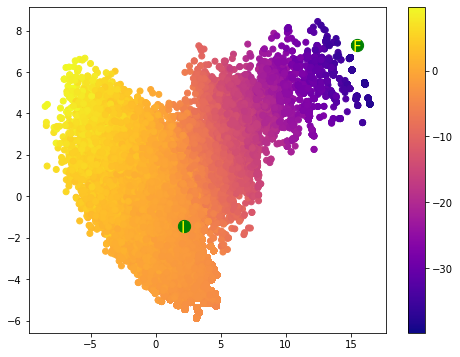

In [33]:
X = h5file["pca_all_coords"][:,0]
Y = h5file["pca_all_coords"][:,1]
Z = h5file["pca_all_coords"][:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=h5file["SIM_G"],
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

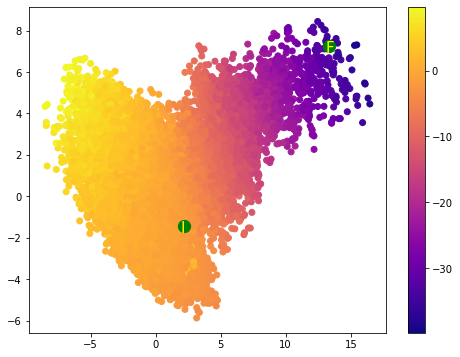

In [34]:
X = h5file["pca_coords"][:,0]
Y = h5file["pca_coords"][:,1]
Z = h5file["pca_coords"][:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=h5file["SIM_G_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

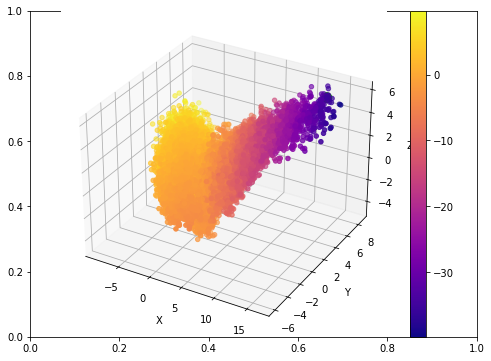

In [201]:
X = h5file["pca_coords"][:,0]
Y = h5file["pca_coords"][:,1]
Z = h5file["pca_coords"][:,2]

# PCA: 3 components
fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(X,Y,Z,
          c=h5file["SIM_G_uniq"],      
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
z = [Z[0], Z[-1]]
ax.scatter(x,y,z,s=100,c="green",alpha=1)

#### Try use PCA directly without AE

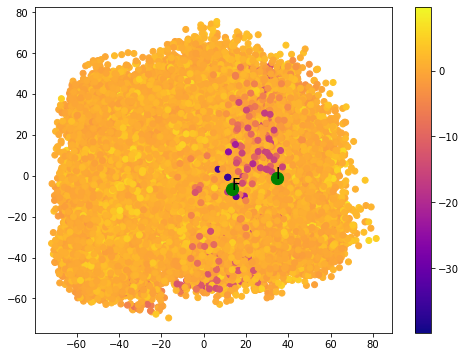

In [202]:
# pca_coords1 = PCA(n_components=3).fit_transform(npyfile["SIM_scar_uniq"])  # single trj
pca_coords1 = PCA(n_components=3).fit_transform(h5file["SIM_scar_uniq"])   # multiple trj

X = pca_coords1[:,0]
Y = pca_coords1[:,1]
Z = pca_coords1[:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=h5file["SIM_G_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="black")

### 2. PHATE Vis

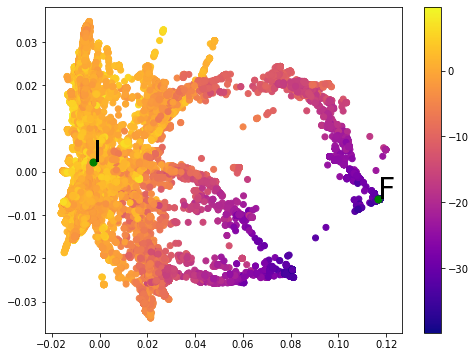

In [203]:
X_phate = h5file["phate_all_coords"][:,0]
Y_phate = h5file["phate_all_coords"][:,1]

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X_phate,Y_phate,
                c=h5file["SIM_G"],   # multiple trj               
                cmap='plasma',
               )

plt.colorbar(im)

annotations=["I","F"]
x = [X_phate[0],X_phate[-1]]
y = [Y_phate[0],Y_phate[-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=30,c="black")

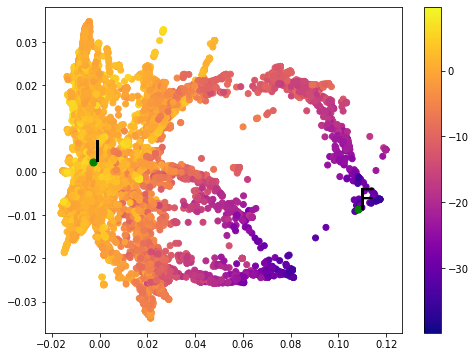

In [204]:
X_phate = h5file["phate_coords"][:,0]
Y_phate = h5file["phate_coords"][:,1]

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X_phate,Y_phate,
                c=h5file["SIM_G_uniq"],                 
                cmap='plasma',
               )

plt.colorbar(im)

annotations=["I","F"]
x = [X_phate[0],X_phate[-1]]
y = [Y_phate[0],Y_phate[-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=30,c="black")

#### PHATE without AE

Calculating PHATE...
  Running PHATE on 71580 observations and 4000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 13.95 seconds.
    Calculating KNN search...
    Calculated KNN search in 216.24 seconds.
    Calculating affinities...


/Users/chenwei/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 401 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.22 seconds.
  Calculated graph and diffusion operator in 230.42 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 5.37 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.56 seconds.
  Calculated landmark operator in 16.05 seconds.
  Calculating optimal t...
    Automatically selected t = 44
  Calculated optimal t in 6.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.93 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.55 seconds.
Calculated PHATE in 256.17 seconds.


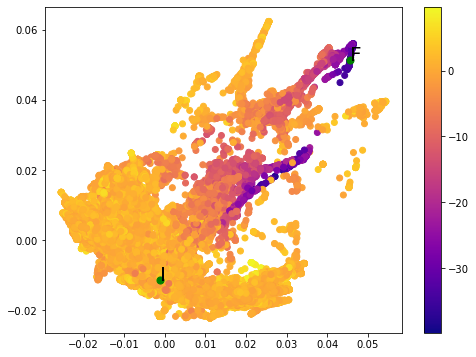

In [96]:
phate_operator = phate.PHATE(n_jobs=-2)
# phate1 = phate_operator.fit_transform(npyfile["SIM_scar_uniq"])   # single trj
phate1 = phate_operator.fit_transform(h5file["SIM_scar_uniq"])   # multiple trj`


fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(phate1[:,0],
          phate1[:,1],
          c=h5file["SIM_G_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [phate1[:,0][0],phate1[:,0][-1]]
y = [phate1[:,1][0],phate1[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")